# Hacking Structural Biology with Python and Pandas
### by Chris Ing, 2015, https://github.com/cing/HackingStructBiolTalk (reduced dataset version)

In [1]:
%matplotlib inline

from __future__ import print_function
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

import mdtraj as md
from mdtraj.html import TrajectoryView, enable_notebook

enable_notebook()

<IPython.core.display.Javascript object>

In [2]:
# RGB colors used for plotting later on!
mode_color_dict = {'CC': (0.24309112394557281, 0.55515571552164411, 0.58454442129415629, 1.0),
 'E': (1.0, 0.50591311045721465, 0.0031372549487095253, 1.0),
 'EC': (0.89411765336990356, 0.10196078568696976, 0.10980392247438431, 1.0),
 'EL': (0.88366013765335083, 0.77908497055371606, 0.18562091886997223, 1.0),
 'LT': (0.86772780488519108, 0.45231836227809685, 0.5609227340011036, 1.0),
 'NONE': (0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 1.0),
 'S': (0.49803923567136127, 0.43267975250879925, 0.52287583549817396, 1.0)}

* * *

### 1)  What are proteins and what is structural biology?


|  ![Protein Sequence in DNA](assets/LysozymeSequence.png) | ![Protein Structure](assets/LysozymeStructure.gif) | ![Protein Strucure with Sugar](assets/LysozymeRock.gif) |
|:-:|:-:|:-:|
|  Sequence | Structure | Function  |



### 2) How do we do molecular dynamics?

|  ![Building Molecular Models](assets/MDpdb.png) | ![Molecular Dynamics Force Fields](assets/MDforcefield.png) | ![Dog-Based Billiards Simulations](assets/MDsimulate.gif) |
|:-:|:-:|:-:|
| Build Molecular Model  | Define Parameters and Interactions | Simulation  |

* * *

In [3]:
# Building a molecular model
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

fixer = PDBFixer(url="http://www.rcsb.org/pdb/files/3WVY.pdb")
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.removeHeterogens(False)
fixer.addMissingHydrogens(7.0)
PDBFile.writeFile(fixer.topology, fixer.positions,
                  open('assets/3WVY_simulation.pdb', 'w'))

In [4]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
from sys import stdout

# Load protein structure and force field
pdb = app.PDBFile('assets/3WVY_simulation.pdb')
forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')

# Define system and integrator
system = forcefield.createSystem(pdb.topology, 
                                 nonbondedMethod=app.CutoffNonPeriodic,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds)
integrator = mm.LangevinIntegrator(300*unit.kelvin,
                                   1.0/unit.picoseconds, 
                                   2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

# Select compute platform and energy minimize
platform = mm.Platform.getPlatformByName('OpenCL')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

# Set initial velocities and output logging
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
simulation.reporters.append(app.DCDReporter('assets/3WVY_trajectory.dcd', 100))
simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    temperature=True, progress=True, remainingTime=True, 
    speed=True, totalSteps=7500, separator='\t'))

# Execute molecular dynamics simulation
simulation.step(7500)
print("Done!")

#"Progress (%)"	"Step"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
3.3%	250	223.750720342	0	--
6.7%	500	251.312229415	44.1	0:27
10.0%	750	274.548497163	44.6	0:26
13.3%	1000	278.167108353	44.2	0:25
16.7%	1250	282.952007316	44.4	0:24
20.0%	1500	299.009790356	44.3	0:23
23.3%	1750	296.151914463	44.5	0:22
26.7%	2000	300.337820208	44.5	0:21
30.0%	2250	300.431680216	44.4	0:20
33.3%	2500	307.332308314	44.4	0:19
36.7%	2750	301.587510278	44.6	0:18
40.0%	3000	302.738097112	44.6	0:17
43.3%	3250	297.181873233	44.7	0:16
46.7%	3500	297.490553308	44.7	0:15
50.0%	3750	301.58296237	44.8	0:14
53.3%	4000	317.612161711	44.8	0:13
56.7%	4250	301.61238856	44.8	0:12
60.0%	4500	318.335221377	44.8	0:11
63.3%	4750	302.334985014	44.9	0:10
66.7%	5000	298.462579908	44.9	0:09
70.0%	5250	298.015967148	44.9	0:08
73.3%	5500	305.097821032	44.9	0:07
76.7%	5750	313.194769668	44.9	0:06
80.0%	6000	326.225738762	44.9	0:05
83.3%	6250	317.691217746	44.9	0:04
86.7%	6500	312.928771406	44.9	0:03
90.0%	6750	305.877736116	45

### 3) What does molecular dynamics look like?

In [5]:
lysozyme_traj = md.load("assets/3WVY_trajectory.dcd",
                        top="assets/3WVY_simulation.pdb")

#widget = TrajectoryView(lysozyme_traj, primaryStructure="sphere")
widget = TrajectoryView(lysozyme_traj, secondaryStructure="ribbon")
widget

In [6]:
for i in range(lysozyme_traj.n_frames):
    widget.frame = i
    time.sleep(0.01)

In [7]:
lysozyme_traj.xyz.shape

(74, 1958, 3)

* * *

### 4) What are ion channels?

|  ![Brain Contains Neurons](assets/Synapse.gif) | ![Neurons Contain Ion Channels](assets/Synapse2.gif) |
|:-:|:-:|
|  Neuron in the brain  | Ions flow through proteins in the cell membrane |



### 5) Building a molecular model of the sodium channel

![Molecular Model of Sodium Channel](assets/NavAbSystemIsometric.gif)

### 6) A few months of molecular dynamics later...

In [8]:
channel_traj = md.load("assets/prod_7_view.xtc",
                       top="assets/na_prod_view.gro")
widget2 = TrajectoryView(channel_traj, secondaryStructure="ribbon")
widget2

In [9]:
for i in range(channel_traj.n_frames)[0:100]:
    widget2.frame = i
    time.sleep(0.01)

### 7) Extract ions within the channel

![Reducing Dataset Complexity for Studies of Ion Channels](assets/NavAbSideViewRawData.png)

In [10]:
# Get the indices of eight atoms
ref_residues = ['residue 175','residue 617', 'residue 396', 'residue 838',
                'residue 178', 'residue 620', 'residue 399', 'residue 841']
ref_indices = channel_traj.topology.select("name CA and ("+" or ".join(ref_residues)+")")

# Extract the positions of all indices and take the mean
ref_xyz = channel_traj.xyz[:,ref_indices,:].mean(axis=1)

print(ref_xyz.shape)
print(ref_xyz[0,:]) # This is the zeroth frames X,Y,Z center of mass

(501, 3)
[ 3.9476254   3.95237541  3.96187544]


In [11]:
# Get a timeseries of all ions and subtract the reference point
ion_indices = channel_traj.topology.select("name NA")

# Subtract the reference point (swapaxes is needed for broadcast)
ion_xyz = channel_traj.xyz[:,ion_indices,:].swapaxes(0,1) - ref_xyz

# Do a boolean check to determine which ions are within the cylinder of radius 1.0
ion_xyz2 = ion_xyz**2
inside_cylinder = (ion_xyz2[:,:,0]+ion_xyz2[:,:,1]) < 1.0**2

print(inside_cylinder.shape)
print(inside_cylinder)

(47, 501)
[[False False False ..., False False False]
 [False False False ...,  True False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [12]:
# Extract the unique ID for each ion
ion_index, time_index = np.where(inside_cylinder)
print(zip(ion_index, time_index)[30:50])

ion_index_in_whole_system = ion_indices[ion_index]
resids = [channel_traj.topology.atom(i).residue.resSeq for i in ion_index_in_whole_system]

[(1, 293), (1, 297), (1, 310), (1, 338), (1, 349), (1, 470), (1, 491), (1, 498), (2, 26), (2, 83), (2, 199), (2, 225), (2, 232), (2, 265), (2, 270), (2, 299), (2, 314), (2, 316), (2, 341), (2, 364)]


### 8) Construct a dataframe with ion positions

In [13]:
# Construct a dataframe with this positional data
ion_positions_df = pd.DataFrame(ion_xyz[inside_cylinder]*10, columns=["X","Y","Z"])
ion_positions_df["ResidID"] = resids
ion_positions_df["Frame"] = time_index+1
ion_positions_df["Time"] = (time_index)*2.0
time_sorted_ions = ion_positions_df.sort_values("Frame").reset_index(drop=True)
time_sorted_ions[(time_sorted_ions["Z"] > -10) & (time_sorted_ions["Z"] < 10)]

,X,Y,Z,ResidID,Frame,Time
2,0.013747,0.206249,1.191249,12051,1,0
4,0.433745,-0.001249,1.331248,12051,2,2
7,0.313749,-0.033751,1.747499,12051,3,4
10,0.331249,0.117500,1.617501,12051,4,6
16,0.149996,0.017498,1.331248,12051,5,8
18,0.194998,0.166249,1.060004,12051,6,10
21,0.075002,0.102501,1.017499,12051,7,12
23,-0.368750,0.381250,1.408751,12051,8,14
25,0.286250,0.048752,1.546249,12051,9,16
26,1.526248,0.193748,6.633751,12036,10,18


### 9) Load a dataframe with the full ion dataset

In [14]:
coord_1st = pd.read_pickle("assets/NAVAB_XTAL_PD-NORES-0kcal-CHARMM_NONB_WT_SOD150_DEMO_COORD1ST.pkl")

In [15]:
coord_reduced = coord_1st[["Frame","Time","ResidID","X","Y","Z","TrajNum"]]
coord_subset = coord_reduced[coord_reduced["TrajNum"] == 7]
coord_subset

,Frame,Time,ResidID,X,Y,Z,TrajNum
764793,500,10,12051,-0.1825,0.3075,-1.3900,7
764794,500,10,12043,-0.4525,9.5175,-13.3700,7
765561,1000,20,12036,-0.4013,-0.8813,-7.5663,7
765562,1000,20,12051,0.2288,0.0088,-1.4563,7
766581,1500,30,12051,-0.0525,0.2775,-1.3612,7
766582,1500,30,12065,2.2375,2.6775,-6.2813,7
767300,2000,40,12044,4.9838,-0.9163,-13.3287,7
767301,2000,40,12051,0.1238,0.1538,-1.7688,7
768216,2500,50,12044,0.6975,-0.5800,-2.2963,7
768217,2500,50,12051,-0.3625,-0.0600,3.5538,7


### 10) Detail of the ion channel pore

![Ion Orderings within the Channel](assets/NavAbSideViewOccupancy.png)

### 11) Timeseries of ordered ions inside the channel

In [16]:
gdf = coord_subset.sort_values(["TrajNum","Time","Z"], ascending=(False,True,False))
sizes = gdf.groupby(["TrajNum","Time"]).size().values
gdf["TotalCount"] = np.arange(len(gdf))
gdf["RepeatCumSum"] = np.repeat(sizes.cumsum() - sizes, sizes)
gdf["Order"] = np.arange(len(gdf)) - np.repeat(sizes.cumsum() - sizes, sizes)
gdf

,Frame,Time,ResidID,X,Y,Z,TrajNum,TotalCount,RepeatCumSum,Order
764793,500,10,12051,-0.1825,0.3075,-1.3900,7,0,0,0
764794,500,10,12043,-0.4525,9.5175,-13.3700,7,1,0,1
765562,1000,20,12051,0.2288,0.0088,-1.4563,7,2,2,0
765561,1000,20,12036,-0.4013,-0.8813,-7.5663,7,3,2,1
766581,1500,30,12051,-0.0525,0.2775,-1.3612,7,4,4,0
766582,1500,30,12065,2.2375,2.6775,-6.2813,7,5,4,1
767301,2000,40,12051,0.1238,0.1538,-1.7688,7,6,6,0
767300,2000,40,12044,4.9838,-0.9163,-13.3287,7,7,6,1
768217,2500,50,12051,-0.3625,-0.0600,3.5538,7,8,8,0
768216,2500,50,12044,0.6975,-0.5800,-2.2963,7,9,8,1


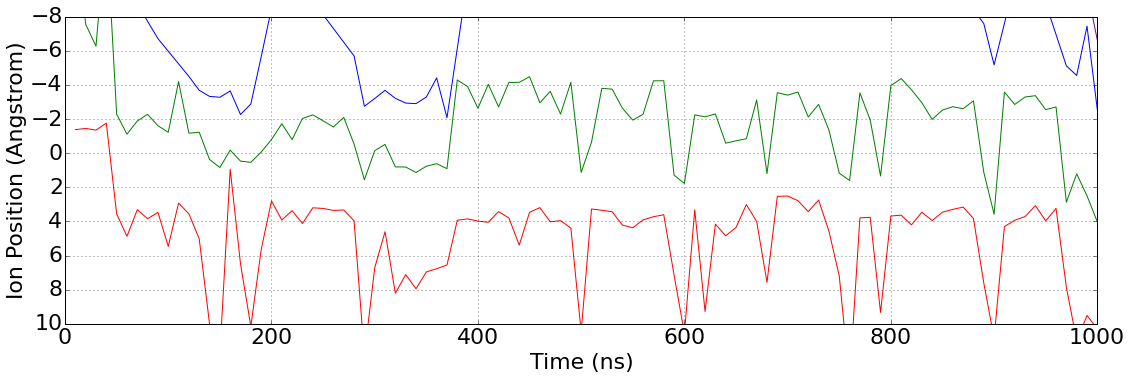

In [31]:
def plot_ts_by_order(coord_df, skip=1):
    f1, ax = plt.subplots(1)
    
    gdf = coord_df.sort_values(["TrajNum","Time","Z"], ascending=(False,True,False))
    sizes = gdf.groupby(["TrajNum","Time"]).size().values
    gdf["Order"] = np.arange(sizes.sum()) - np.repeat(sizes.cumsum() - sizes, sizes) # <-- Wizardry
    ordcolors=["red","green","blue","purple","orange","pink","aqua","maroon"]
    for ordatom, data in gdf.groupby("Order"):
        points = data[["Time","Z"]].values
        ax.plot(points[:,0][::skip], points[:,1][::skip], color=ordcolors[ordatom])
    
    ax.set_xlim([0,1000])
    ax.set_ylim([-8,10])
    ax.grid(True)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Ion Position (Angstrom)")
    
    f1.gca().invert_yaxis()
    f1.set_size_inches(18.5, 5.5)

plot_ts_by_order(coord_subset)

### 13) Ion coordination inside the channel

![Ion Coordination in Water and in an Ion Channel](assets/NavAbSideViewCoordination.png)

In [18]:
coord_merge = pd.read_pickle("assets/NAVAB_XTAL_PD-NORES-0kcal-CHARMM_NONB_WT_SOD150_DEMO_MERGE.pkl")
coord_merge

,Frame,X,Y,Z,S178,E177,E177p,L176,T175,W,TrajNum,ResidID,RowID,Time,CoordLabel,CoordLabel_2nd,ModeLabel
669,500,0.0687,0.1812,-1.4200,0,0,0,0,0,6,1,12051,NA+,10,0000,1110,EL
1601,1000,-0.4813,0.0538,-1.1650,0,0,0,0,0,5,1,12051,NA+,20,0000,0110,EL
1602,1000,3.8488,-0.3862,-7.1050,1,0,0,0,0,5,1,12043,NA+,20,1000,1100,S
2709,1500,-0.6425,-0.8100,3.2613,0,0,0,0,0,6,1,12051,NA+,30,0000,0011,LT
2710,1500,0.4675,-0.0600,-2.1487,0,0,0,0,0,6,1,12043,NA+,30,0000,1110,EL
3794,2000,5.5337,-3.0650,-13.9875,0,0,0,0,0,4,1,12033,NA+,40,0000,0000,EC
3795,2000,0.5837,1.6950,0.5725,0,1,0,1,0,4,1,12051,NA+,40,0110,0111,EL
3796,2000,0.3737,0.8150,-3.1575,0,1,0,0,0,4,1,12043,NA+,40,0100,1100,E
4845,2500,0.1825,1.3175,1.6613,0,1,0,1,0,3,1,12051,NA+,50,0110,0011,EL
4846,2500,0.7225,-0.1625,-1.6487,0,1,0,0,0,4,1,12043,NA+,50,0100,1110,E


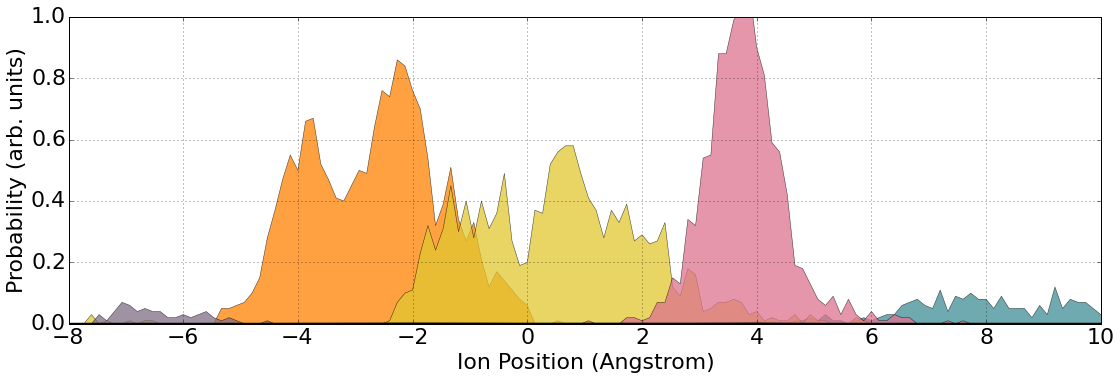

In [38]:
def plot_modehist(coord_merge, norm_factor=0.01):
    f1, ax = plt.subplots(1)
    f1.set_size_inches(18.5, 5.5)
    
    # Histogram and plot the position distribution of each mode.
    for coordlabel, v in coord_merge.groupby("ModeLabel"):
        histogram, edges = np.histogram(v["Z"], bins=300, range=[-20,20], normed=False)                                              
        ax.fill_between(edges[1:], 0, histogram*norm_factor,
                                              linewidth=0.5,
                                              facecolor=mode_color_dict[coordlabel],
                                              alpha=0.75)
        
    # Show the sum of all modes too...
    histogram, edges = np.histogram(coord_merge["Z"], bins=300, range=[-20,20], normed=False)
    ax.plot(edges[1:], histogram*0.00001, linewidth=2.0, color="black")
    
    ax.set_xlim([-8,10])
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xlabel("Ion Position (Angstrom)")
    ax.set_ylabel("Probability (arb. units)")
    
plot_modehist(coord_merge)

### 14) Studying protein flexibility in the channel

![Ion Channels Are Flexible](assets/NavAbSideViewDunking.png)

In [20]:
dihe_ts = pd.read_pickle("assets/NAVAB_XTAL_PD-NORES-0kcal-CHARMM_NONB_WT_SOD150_DEMO_DIHE.pkl")
dihe_ts[["Frame","Time","S1-Chi2","S2-Chi2","S3-Chi2","S4-Chi2","TrajNum"]]

,Frame,Time,S1-Chi2,S2-Chi2,S3-Chi2,S4-Chi2,TrajNum
499,500,10,73.892,36.320,301.221,301.673,1
999,1000,20,333.938,43.428,306.579,79.402,1
1499,1500,30,303.713,286.884,303.528,303.080,1
1999,2000,40,323.949,299.396,312.750,291.897,1
2499,2500,50,300.581,293.666,85.650,287.496,1
2999,3000,60,301.213,312.540,95.065,292.090,1
3499,3500,70,310.511,48.897,294.006,307.242,1
3999,4000,80,302.491,79.076,57.945,295.435,1
4499,4500,90,289.829,50.219,290.140,306.218,1
4999,5000,100,76.211,81.412,301.120,307.405,1


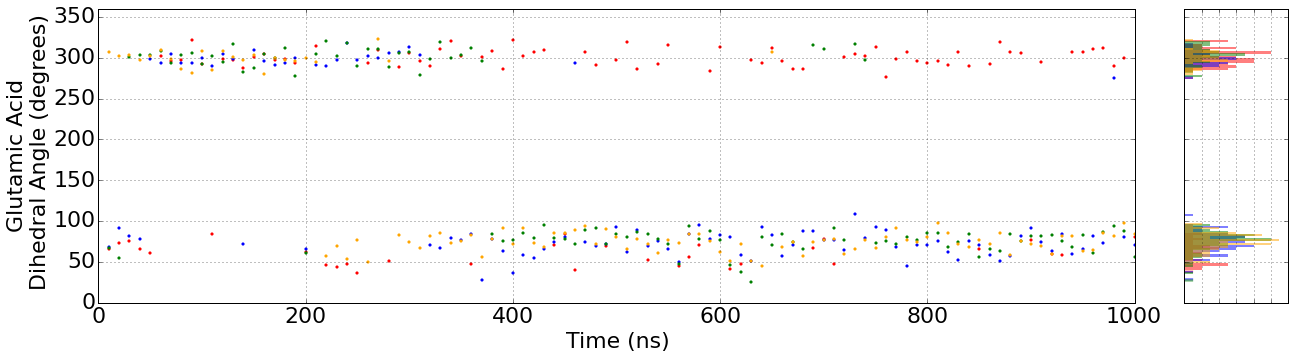

In [36]:
def plot_glu_timeseries(dihe_ts, traj=7):
    fig = plt.figure(figsize=(18.5, 5.5))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[10, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    ax1.tick_params(labelbottom='off',labelleft='off')
    ax1.set_ylim([0,360])
    ax1.grid(True)
    
    plotcols = ["S1-Chi2","S2-Chi2","S3-Chi2","S4-Chi2"]
    plotrgb = ["red","blue","green","orange"]
    
    dihe_subset = dihe_ts[dihe_ts["TrajNum"]==traj]
    
    dihe_plotargs = dict(ylim=[0,360], kind="scatter", ax=ax0, marker="o", lw=0, s=10, xlim=[0,1000], grid=True)
    for column, color in zip(plotcols, plotrgb):
        dihe_subset.plot("Time", column, color=color, **dihe_plotargs)
        ax1.hist(dihe_subset[column].values, bins=100, orientation='horizontal', alpha=0.5, color=color, lw=0)
    
    ax0.set_ylabel("Glutamic Acid \n Dihedral Angle (degrees)")
    ax0.set_xlabel("Time (ns)")
    
    plt.tight_layout()
    
plot_glu_timeseries(dihe_ts, 7)

### 15) Restricting protein conformations

In [22]:
# Unpickle some dataframes of restricted GLU simulations
coord_merge2 = pd.read_pickle("assets/NAVAB_XTAL_PD-DIHEREST-CHARMM_NONB_WT_SOD150_DEMO_MERGE.pkl")

# Unpickle some dihedral angle data for those simulations
dihe_ts2 = pd.read_pickle("assets/NAVAB_XTAL_PD-DIHEREST-CHARMM_NONB_WT_SOD150_DEMO_DIHE.pkl")

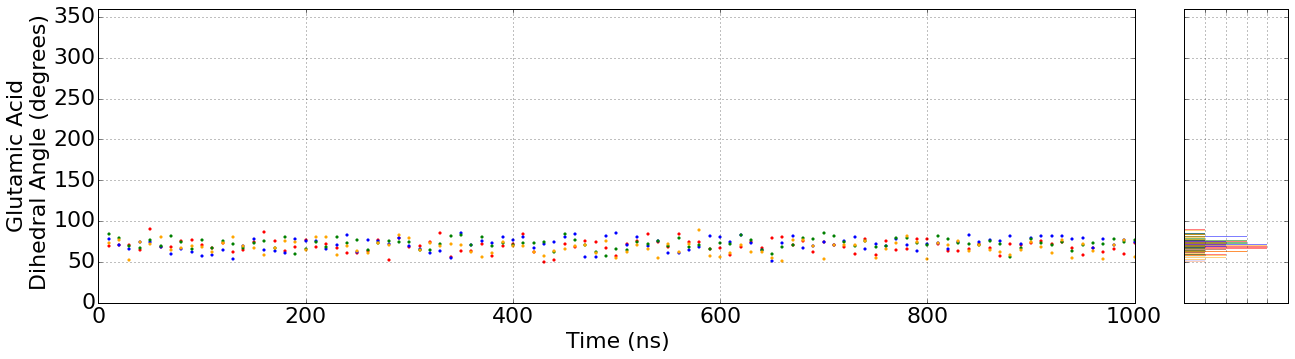

In [37]:
plot_glu_timeseries(dihe_ts2, 7)

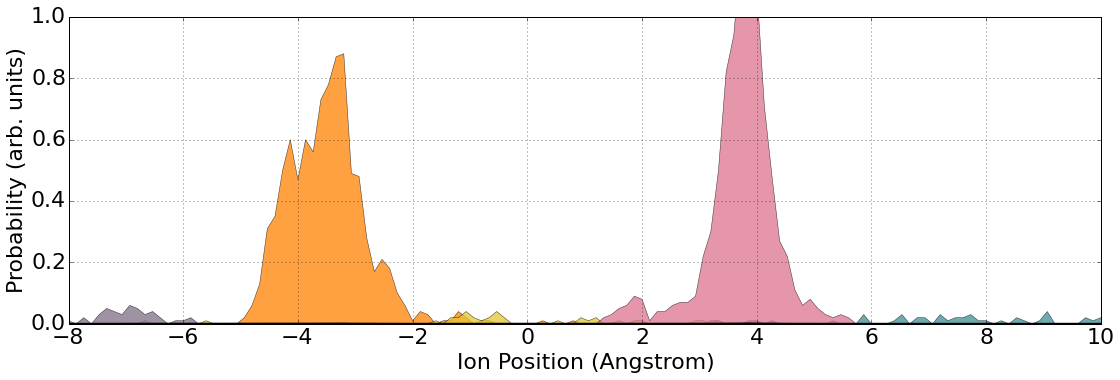

In [41]:
plot_modehist(coord_merge2)

By restricting protein flexibility we totally disrupted ion binding, what's going on? Keep an eye out for our coming papers...

### 16) Acknowledgements

Thanks to all members of the Régis Pomès laboratory, especially Nilmadhab Chakrabarti. Thanks to collaborators in the Catterall and Zheng laboratories. Thanks to the Pande Laboratory (and collaborators) for driving structural biology further using Python (see http://www.omnia.md). Thanks to the Fundamentals of Neuroscience MOOC for neuron images (https://www.mcb80x.org/).

|  ![title](assets/ThanksCC.png) | ![title](assets/ThanksCIHR.jpg) | ![title](assets/ThanksUofT.png) |
|:-:|:-:|:-:|
|  ![title](assets/ThanksSickKids.png) | ![title](assets/ThanksPyCon.png) | ![title](assets/ThanksOpenMM.png)  |